## Non Linearity Analysis

#### Import necessary libraries

In [33]:
from pathlib import Path
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

#### Load the dataset

In [35]:
#pwd

In [36]:
file_path = "../../../data/merged_v2.csv"
# Create a Path object
data_file_path = Path(file_path)
data = pd.read_csv(data_file_path)

#### Display basic dataset information

In [38]:
print("Dataset Information:")
print(data.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longitude   2584 non-null   float64
 1   latitude    2584 non-null   float64
 2   Area        2584 non-null   object 
 3   Soil group  2584 non-null   object 
 4   Land class  2584 non-null   object 
 5   Soil type   2584 non-null   object 
 6   pH          2584 non-null   float64
 7   SOC         2584 non-null   float64
 8   Nitrogen    2584 non-null   float64
 9   Potassium   2584 non-null   float64
 10  Phosphorus  2584 non-null   float64
 11  Sulfur      2584 non-null   float64
 12  Boron       2584 non-null   float64
 13  Zinc        2584 non-null   float64
 14  Sand        2584 non-null   float64
 15  Silt        2584 non-null   float64
 16  Clay        2584 non-null   float64
dtypes: float64(13), object(4)
memory usage: 343.3+ KB
None


### Check for missing values

In [40]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
longitude     0
latitude      0
Area          0
Soil group    0
Land class    0
Soil type     0
pH            0
SOC           0
Nitrogen      0
Potassium     0
Phosphorus    0
Sulfur        0
Boron         0
Zinc          0
Sand          0
Silt          0
Clay          0
dtype: int64


#### Display the first few rows

In [42]:
print(f"\nData file: {data_file_path.name}")
print("-" * 24, "\n")
data.head()


Data file: merged_v2.csv
------------------------ 



,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
0,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,33.0
1,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,33.0
2,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,33.0
3,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00,33.0,33.0,33.0
4,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04,33.0,33.0,33.0


#### Define target variables and features

In [44]:
targets = ["SOC", "Boron", "Zinc"]  
features = [col for col in data.columns if col not in targets]

In [45]:
features

['longitude',
 'latitude',
 'Area',
 'Soil group',
 'Land class',
 'Soil type',
 'pH',
 'Nitrogen',
 'Potassium',
 'Phosphorus',
 'Sulfur',
 'Sand',
 'Silt',
 'Clay']

#### Handle longitude and latitude

##### Challenges with Raw Longitude and Latitude

1. Collinearity:

    - Longitude and latitude are often highly correlated (as observed in the correlation matrix). 
    High collinearity can:
        - Introduce redundancy in the feature set.
        - Cause instability in linear models like LASSO, as they struggle to assign proper weights to correlated variables.

2. Interpretability:

    - Raw coordinates provide little intuitive insight into relationships with the target variables.
    - Clusters make it easier to associate geospatial regions with the behavior of the target variables.

3. Scale and Units:

    - Longitude and latitude have arbitrary numerical ranges that might not be meaningful directly.
    - Transforming them into clusters captures relative spatial patterns more effectively.

##### Why Use Geo Clustering?

1. Captures Geospatial Influence:

    - Soil properties like SOC, Boron, and Zinc are likely influenced by geographical factors such as climate, soil types, and topography.
    - Clustering groups locations with similar geographic properties into meaningful categories.

2. Reduces Complexity:

    - Instead of treating longitude and latitude as continuous variables, clustering simplifies them into a single categorical feature (geo_cluster).

3. Mitigates Collinearity:

    - By combining the two features into a single cluster feature, we reduce collinearity and improve model stability.

4. Preserves Regional Relationships:

    - Clustering preserves regional relationships that may correlate strongly with the target variables.

##### K-Means for Clustering

- Why K-Means?

    - K-Means is simple, efficient, and works well for identifying groups based on proximity in the coordinate space.
    - It assigns each point to a cluster, capturing geospatial regions effectively.

- Number of Clusters (k):

    - A small number of clusters (e.g., 5) balances granularity and interpretability.
    - The exact number can be tuned based on the dataset's characteristics.

##### Impact on Model Selection

- LASSO Regression:

    - Including geo_cluster ensures that LASSO can leverage geospatial influences without being affected by collinearity.
    - The simplified feature makes interpretation easier.

- Tree-Based Models:

    - Models like Random Forest or Gradient Boosting can capture both linear and non-linear interactions between geo_cluster and the target variables.

In [55]:
if 'longitude' in features and 'latitude' in features:
    # Create a combined geospatial clustering feature
    kmeans = KMeans(n_clusters=5, random_state=42)
    data['geo_cluster'] = kmeans.fit_predict(data[['longitude', 'latitude']])
    print("\nGeospatial Clusters Created:")
    print(data['geo_cluster'].value_counts())

    # Include the new feature and exclude raw longitude/latitude
    features.remove('longitude')
    features.remove('latitude')
    features.append('geo_cluster')


Geospatial Clusters Created:
geo_cluster
4    618
0    611
2    478
1    477
3    400
Name: count, dtype: int64


#### Select only numeric features

In [57]:
numeric_features = data[features].select_dtypes(include=np.number).columns.tolist()

#### Calculate mutual information scores

In [59]:
mutual_info_results = {}
for target in targets:
    X = data[numeric_features]
    y = data[target]
    mutual_info_results[target] = mutual_info_regression(X, y, random_state=42)

#### Convert mutual information results to a DataFrame

In [61]:
mutual_info_df = pd.DataFrame(mutual_info_results, index=numeric_features)
print("\nMutual Information Scores:")
print("-" * 26, "\n")
print(mutual_info_df)


Mutual Information Scores:
-------------------------- 

                  SOC     Boron      Zinc
pH           0.176976  0.207365  0.068706
Nitrogen     0.837594  0.459310  0.201741
Potassium    0.201948  0.316707  0.174331
Phosphorus   0.078651  0.152122  0.062547
Sulfur       0.312030  0.265683  0.122807
Sand         0.341192  0.429828  0.229728
Silt         0.266486  0.384488  0.212702
Clay         0.259043  0.340490  0.206485
geo_cluster  0.281744  0.440034  0.277091


#### Plot mutual information scores

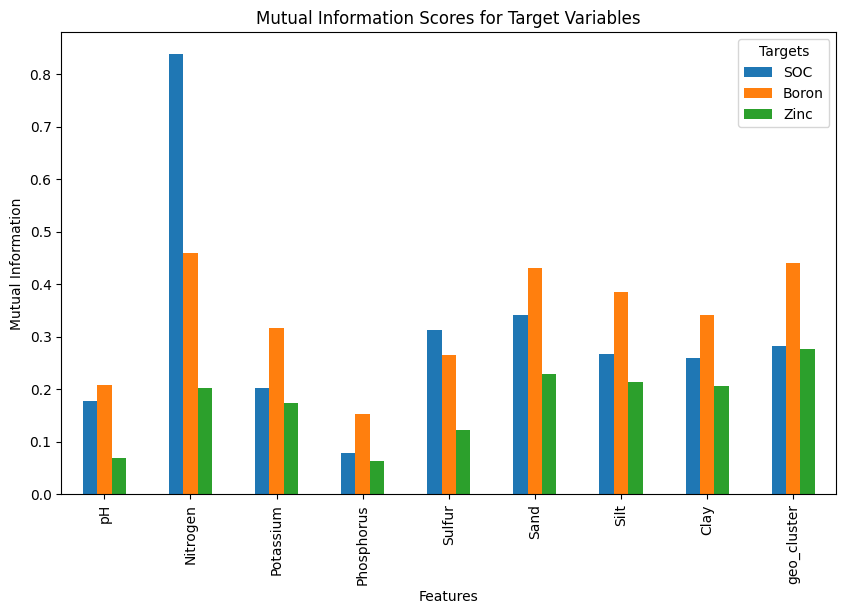

In [63]:
mutual_info_df.plot(kind='bar', figsize=(10, 6))
plt.title('Mutual Information Scores for Target Variables')
plt.ylabel('Mutual Information')
plt.xlabel('Features')
plt.legend(title='Targets')
plt.show()

#### Compute correlation matrix

In [65]:
corr_matrix = data[numeric_features + targets].corr()

#### Plot correlation matrix

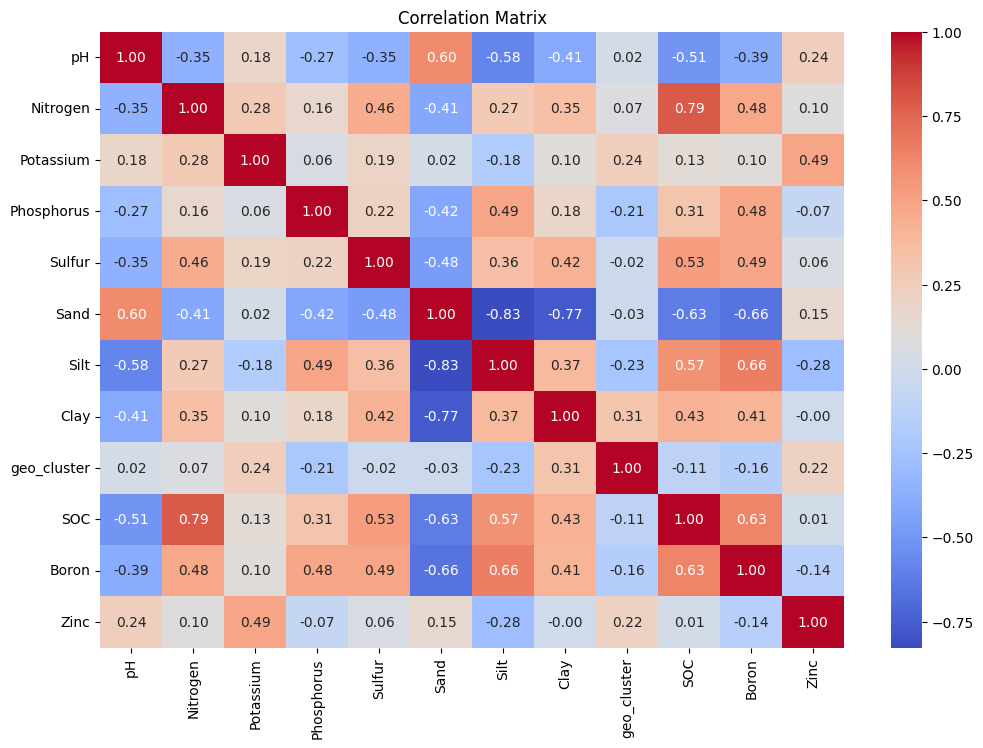

In [67]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### Suggest models based on analysis

In [69]:
print("\nModel Suggestions:")
print("-" * 18, "\n")
for target in targets:
    print(f"\nTarget: {target}")
    high_mutual_info_features = mutual_info_df[target][mutual_info_df[target] > 0.3].index.tolist()
    print(f"High Mutual Information Features: {high_mutual_info_features}")
    if 'geo_cluster' in high_mutual_info_features:
        print("Suggested Models: LASSO (with feature engineering), Tree-based models (e.g., Random Forest)")
    elif len(high_mutual_info_features) > 3:
        print("Suggested Models: LASSO, Ridge Regression")
    else:
        print("Suggested Models: Linear Regression or LASSO, Elastic Net")


Model Suggestions:
------------------ 


Target: SOC
High Mutual Information Features: ['Nitrogen', 'Sulfur', 'Sand']
Suggested Models: Linear Regression or LASSO, Elastic Net

Target: Boron
High Mutual Information Features: ['Nitrogen', 'Potassium', 'Sand', 'Silt', 'Clay', 'geo_cluster']
Suggested Models: LASSO (with feature engineering), Tree-based models (e.g., Random Forest)

Target: Zinc
High Mutual Information Features: []
Suggested Models: Linear Regression or LASSO, Elastic Net


## Final Conclusion

The transformation of longitude and latitude into geo_cluster helps:

1. Simplify the feature set.
2. Enhance interpretability.
3. Reduce collinearity.
4. Capture meaningful geospatial patterns.



- geo_cluster is included as a high mutual information feature for Boron.

    - This indicates that the transformation of longitude and latitude into geo_cluster effectively captures the geospatial relationships relevant to Boron.
- For other targets (SOC and Zinc), geo_cluster does not appear in the list of high mutual information features.

    - This suggests that raw longitude and latitude are not directly influential and their transformation to geo_cluster did not add predictive value for these targets.

Safe to Drop longitude and latitude
- Since geo_cluster is derived from longitude and latitude, and it encapsulates geospatial influence for Boron, we can safely drop the raw longitude and latitude columns.
- This will simplify the feature set without losing predictive information for any target variable.

##### Model Selection

1. Target: SOC
- High Mutual Information Features: Nitrogen, Sulfur, Sand
- Reasoning:
    - The high mutual information features suggest a predominantly linear relationship with the target variable.
    - The number of relevant features is small, indicating that simpler linear models can capture the relationships effectively.
- Selected Models:
    - Linear Regression or LASSO: Both are suitable for capturing linear dependencies.
    - Elastic Net: For balancing feature selection and multicollinearity handling, if present.

2. Target: Boron
- High Mutual Information Features: Nitrogen, Potassium, Sand, Silt, Clay, geo_cluster
- Reasoning:
    - The inclusion of multiple features, including geo_cluster, indicates complex relationships involving geospatial and compositional factors.
    - The presence of multiple high-information features makes models with feature selection or handling non-linear interactions more suitable.
- Selected Models:
    - LASSO (with feature engineering): For feature selection and handling a large number of predictors.
    - Tree-Based Models (e.g., Random Forest, Gradient Boosting): To capture non-linear interactions and higher-order relationships.

3. Target: Zinc
- High Mutual Information Features: None
- Reasoning:
    - The lack of high mutual information features suggests weak direct relationships between the predictors and the target variable.
    - Simpler linear models can still provide robust predictions by focusing on minimal assumptions about the feature set.
- Selected Models:
    - Linear Regression or LASSO: Suitable for weak relationships to explore patterns while performing regularization (in LASSO).
    - Elastic Net: For scenarios where multicollinearity is present or suspected.